# Projecto Final MDADM

## Imports

In [22]:
from os import name
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.matlab as matlab
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, f1_score, roc_curve, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import warnings



## Carga de datos y distribucion de clases

In [23]:
#Tratamiento de warnings
warnings.filterwarnings("ignore")

# Load the database
mat_file =  "BigDigits.mat"
mat = matlab.loadmat(mat_file,squeeze_me=True) # dictionary
list(mat.keys()) # list vars

taska = False

data = mat["data"]      # read feature vectors
labs = mat["labs"] - 1  # read labels 1..10

allNlabs = np.unique(labs) # all labs 0 .. 9

classsiz = ()
for c in allNlabs:
    classsiz = classsiz + (np.size(np.nonzero(labs==c)),)  
print ('\n%% Class labels are: %s' % (allNlabs,) )   
print ('%% Class frequencies are: %s' % (classsiz,))


# Let's say my digit is ...
myDigit = 5

otherDigits  = np.setdiff1d(allNlabs,myDigit)
other3Digits = np.random.permutation(otherDigits)[:3]

if taska:
    others = other3Digits
else:
    others = otherDigits

print ('class 1 = %s' % myDigit)
print ('class 2 = %s' % others)

# To construct a 2-class dataset you can use the same matrix
# data and change the vector of labels

aux = labs
classone = np.in1d(labs,myDigit)
classtwo = np.in1d(labs,others)
aux[classone] = 0  # class one
aux[classtwo] = 1  # class two

# Features
X = data[np.logical_or(classone,classtwo)]
# (unchanged) labels
y = aux[np.logical_or(classone,classtwo)]


% Class labels are: [0 1 2 3 4 5 6 7 8 9]
% Class frequencies are: (980, 1135, 1032, 1010, 982, 892, 958, 1028, 974, 1009)
class 1 = 5
class 2 = [0 1 2 3 4 6 7 8 9]


## Muestra de digitos de ambas clases

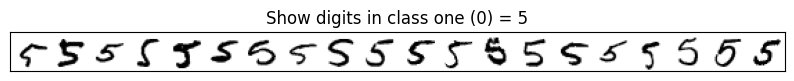

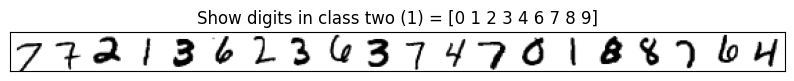

In [24]:
# Show some digits

hwmny = 20
some1 = np.random.permutation(np.where(y==0)[0])[:hwmny]
some2 = np.random.permutation(np.where(y==1)[0])[:hwmny]

img1 = np.reshape(X[some1,:],(28*hwmny,28)).T
plt.figure(figsize=(10,3))
plt.imshow(img1, cmap=plt.cm.gray_r)
plt.xticks([])
plt.yticks([])
plt.title('Show digits in class one (0) = '+str(myDigit) )
plt.show()


img2 = np.reshape(X[some2,:],(28*hwmny,28)).T
plt.figure(figsize=(10,3))
plt.imshow(img2, cmap=plt.cm.gray_r)
plt.xticks([])
plt.yticks([])
plt.title('Show digits in class two (1) = '+str(others) )
plt.show()

In [25]:
train_quantity = 500

train_size = train_quantity / len(labs)  # variable para el train y el test

X_train, X_test, y_train, y_test = train_test_split(data, labs, train_size=train_size)

## Modelo Linear

In [26]:
class Linear:
    def __init__(self):
        self.model = LogisticRegression()

    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def evaluate_f1(self, X_test, y_test):
        y_pred = self.model.predict(X_test)
        return f1_score(y_test, y_pred, average="macro")
   
    def evaluate_f1_t(self, X_test, y_test, threshold=0.7):
        y_proba = self.model.predict_proba(X_test)
        predictions = (y_proba[:, 1] >= threshold).astype(int)
        mask = y_proba.max(axis=1) >= threshold
        y_test_array = np.array(y_test)  # Convertir y_test a un array de NumPy
        y_test_filt = y_test_array[mask]
        y_pred_filt = predictions[mask]
        return (
            f1_score(y_test_filt, y_pred_filt, average="macro"),
            y_test_filt,
            y_pred_filt,
        )
       
    def roc_curve(self, X_test, y_test):
        y_prob = self.model.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])
        return fpr, tpr, thresholds

    def predict(self, X_test):
        return self.model.predict(X_test)

## Creación, entrenamiento, evaluación y ROC de Linear

In [27]:
#Crear el modelo
model = Linear()

# Entrenar el modelo
model.fit(X_train, y_train)

# Evaluar el modelo
f1 = model.evaluate_f1_t(X_test, y_test)
print("F1 Score:", f1)

# Hacer predicciones
y_pred = model.predict(X_test)

# Calcular métricas adicionales
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# Obtener la curva ROC
fpr_linear, tpr_linear, thresholds_linear = model.roc_curve(X_test, y_test)
roc_auc_linear = auc(fpr_linear, tpr_linear)

F1 Score: (0.8569706645207182, array([0, 1, 1, ..., 1, 1, 1], shape=(9429,), dtype=uint8), array([0, 1, 1, ..., 1, 1, 1], shape=(9429,)))
Accuracy: 0.9505263157894737
Precision: 0.8463196289339648
Recall: 0.8536390980855533


## Modelo QDA

In [28]:
class QDA:
    def __init__(self):
        self.model = QuadraticDiscriminantAnalysis()

    def fit(self, X_train, y_train):
        """Entrena el modelo QDA con los datos de entrenamiento."""
        self.model.fit(X_train, y_train)

    def evaluate_f1(self, X_test, y_test):
        """Calcula el F1 Score para las predicciones del modelo."""
        qda_pred = self.model.predict(X_test)
        qda_pred = np.where(np.array(qda_pred) <= 0.5, 0, 1)  # Umbral de 0.5
        return f1_score(y_test, qda_pred, average="macro")

    def roc_curve(self, X_test, y_test):
        """Calcula la curva ROC y devuelve FPR, TPR y umbrales."""
        y_scores = self.model.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva
        fpr, tpr, thresholds = roc_curve(y_test, y_scores)
        return fpr, tpr, thresholds

    def predict(self, X_test):
        """Realiza predicciones con el modelo entrenado."""
        return self.model.predict(X_test)

## Creación, entrenamiento, evaluación y ROC de QDA

In [29]:
# Crear el modelo QDA
qda_model = QDA()

# Entrenar el modelo
qda_model.fit(X_train, y_train)

# Evaluar el modelo con F1 Score
f1 = qda_model.evaluate_f1(X_test, y_test)
print("F1 Score:", f1)

# Hacer predicciones
y_pred = qda_model.predict(X_test)

# Calcular métricas adicionales
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision) 
print("Recall:", recall)

# Obtener la curva ROC
fpr_qda, tpr_qda, thresholds_qda = qda_model.roc_curve(X_test, y_test)
roc_auc_qda = auc(fpr_qda, tpr_qda)

F1 Score: 0.49810226279554237
Accuracy: 0.8838947368421053
Precision: 0.5086260893246187
Recall: 0.5034427949190652


## Modelo KNN

In [30]:
from sklearn.neighbors import KNeighborsClassifier


class KNN:
    def __init__(self, n_neighbors=5, weights="uniform", metric="minkowski"):
        self.model = KNeighborsClassifier(
            n_neighbors=n_neighbors, weights=weights, metric=metric
        )

    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def evaluate_f1(self, X_test, y_test):
        y_pred = self.model.predict(X_test)
        return f1_score(y_test, y_pred, average="macro")

    def evaluate_f1_t(self, X_test, y_test, threshold=0.5):
        y_proba = self.model.predict_proba(X_test)
        predictions = (y_proba[:, 1] >= threshold).astype(int)
        mask = y_proba.max(axis=1) >= threshold
        y_test_array = np.array(y_test)  # Convertir y_test a un array de NumPy
        y_test_filt = y_test_array[mask]
        y_pred_filt = predictions[mask]
        return (
            f1_score(y_test_filt, y_pred_filt, average="macro"),
            y_test_filt,
            y_pred_filt,
        )

    def roc_curve(self, X_test, y_test):
        y_prob = self.model.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])
        return fpr, tpr, thresholds

    def predict(self, X_test):
        return self.model.predict(X_test)

## Creación, entrenamiento, evaluación y ROC de QDA

In [ ]:
# Crear el modelo KNN
knn_model = KNN(n_neighbors=7, weights="uniform", metric="minkowski")
knn_model.fit(X_train, y_train)
f1_knn = knn_model.evaluate_f1(X_test, y_test)
print(f"F1 Score: {f1_score}")

# Hacer predicciones
y_pred = knn_model.predict(X_test)

# Calcular métricas adicionales
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Obtener la curva ROC
fpr_knn, tpr_knn, thresholds_knn = knn_model.roc_curve(X_test, y_test)
roc_auc_knn = auc(fpr_knn, tpr_knn)

F1 Score: 0.8257340687778949
Accuracy: 0.9548421052631579
Precision: 0.9511421153022988
Recall: 0.7611869436282412


## Modelo SVM

In [32]:
class SVM:
    def __init__(self, C=1, kernel="linear", random_state=None, probability=True):
        self.model = SVC(
            kernel=kernel, C=C, random_state=random_state, probability=probability
        )

    def fit(self, X_train, y_train):
        """Entrena el modelo SVM con los datos de entrenamiento."""
        self.model.fit(X_train, y_train)

    def evaluate_f1(self, X_test, y_test):
        """Calcula el F1 Score para las predicciones del modelo."""
        y_pred = self.model.predict(X_test)
        return f1_score(y_test, y_pred, average="macro")

    def roc_curve(self, X_test, y_test):
        """Calcula la curva ROC y devuelve FPR, TPR y umbrales."""
        if not self.model.probability:
            raise ValueError("El modelo SVM debe ser inicializado con probability=True para calcular la curva ROC.")
        y_prob = self.model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        return fpr, tpr, thresholds

    def predict(self, X_test):
        """Realiza predicciones con el modelo entrenado."""
        return self.model.predict(X_test)

## Creación, entrenamiento, evaluación y ROC de SVM

In [33]:
# Crear una instancia del modelo SVM
svm_model = SVM(C=1, kernel="linear", random_state=42, probability=True)

# Entrenar el modelo
svm_model.fit(X_train, y_train)

# Evaluar el modelo
f1_score_svm = svm_model.evaluate_f1(X_test, y_test)
print(f"F1 Score del modelo SVM: {f1_score_svm}")

# Hacer predicciones
y_pred = svm_model.predict(X_test)

# Calcular métricas adicionales
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Obtener la curva ROC
fpr_svm, tpr_svm, thresholds_svm = svm_model.roc_curve(X_test, y_test)
roc_auc_svm = auc(fpr_svm, tpr_svm)
print(f"AUC del modelo SVM: {roc_auc_svm}")

TypeError: 'float' object is not callable

## Modelo MLP

In [ ]:
class MLP:
    def __init__(self, hls=(10,), activation="relu", max_iter=1500):
        self.model = MLPClassifier(
            hidden_layer_sizes=hls,
            activation=activation,
            max_iter=max_iter,
        )

    def fit(self, X_train, y_train):
        """Entrena el modelo MLP con los datos de entrenamiento."""
        self.model.fit(X_train, y_train)

    def evaluate_f1(self, X_test, y_test):
        """Calcula el F1 Score para las predicciones del modelo."""
        y_pred = self.model.predict(X_test)
        return f1_score(y_test, y_pred, average="macro")

    def roc_curve(self, X_test, y_test):
        """Calcula la curva ROC y devuelve FPR, TPR y umbrales."""
        y_prob = self.model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        return fpr, tpr, thresholds

    def predict(self, X_test):
        """Realiza predicciones con el modelo entrenado."""
        return self.model.predict(X_test)

## Creación, entrenamiento, evaluación y ROC de MLP

In [ ]:
# Crear una instancia del modelo MLP
mlp_model = MLP(hls=(100,), activation="relu", max_iter=1500)

# Entrenar el modelo
mlp_model.fit(X_train, y_train)

# Evaluar el modelo con F1 Score
f1_score_mlp = mlp_model.evaluate_f1(X_test, y_test)
print("F1 Score del modelo MLP:", f1_score_mlp)

# Hacer predicciones
y_pred = mlp_model.predict(X_test)

# Calcular métricas adicionales
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Obtener la curva ROC
fpr_mlp, tpr_mlp, thresholds_mlp = mlp_model.roc_curve(X_test, y_test)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)
print(f"AUC del modelo MLP: {roc_auc_mlp}")

Accuracy: 0.9555789473684211
Precision: 0.8609975890993546
Recall: 0.8625594742425133
AUC del modelo MLP: 0.911279668015383


## Matriz de confusión modelo SVM

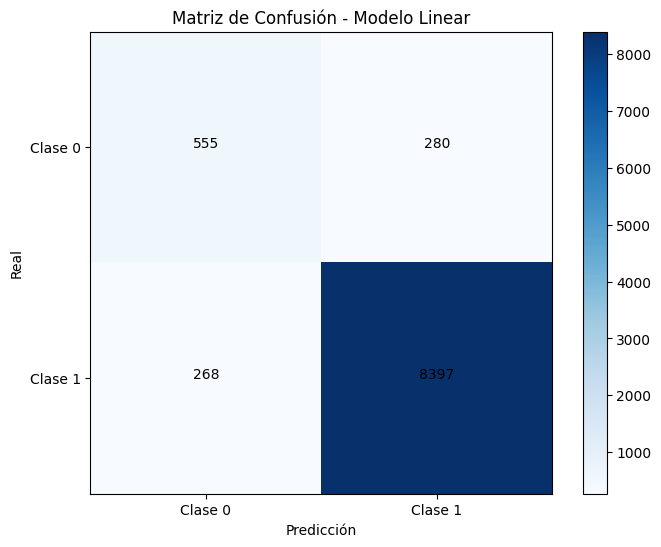

In [ ]:
# Obtener las predicciones del modelo Linear
y_pred_linear = model.predict(X_test)

# Calcular la matriz de confusión
conf_matrix_linear = confusion_matrix(y_test, y_pred_linear)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_linear, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - Modelo Linear")
plt.colorbar()
tick_marks = range(len(np.unique(y_test)))
plt.xticks(tick_marks, ["Clase 0", "Clase 1"])
plt.yticks(tick_marks, ["Clase 0", "Clase 1"])

# Etiquetas y valores en la matriz
for i in range(conf_matrix_linear.shape[0]):
    for j in range(conf_matrix_linear.shape[1]):
        plt.text(j, i, conf_matrix_linear[i, j], horizontalalignment="center", color="black")

plt.ylabel("Real")
plt.xlabel("Predicción")
plt.show()

## Matriz de confusión modelo SVM

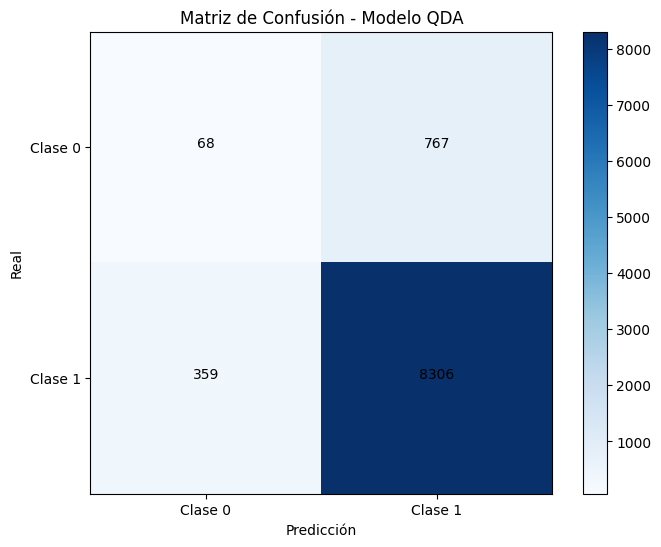

In [ ]:
# Obtener las predicciones del modelo QDA
y_pred_qda = qda_model.predict(X_test)

# Calcular la matriz de confusión
conf_matrix_qda = confusion_matrix(y_test, y_pred_qda)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_qda, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - Modelo QDA")
plt.colorbar()
tick_marks = range(len(np.unique(y_test)))
plt.xticks(tick_marks, ["Clase 0", "Clase 1"])
plt.yticks(tick_marks, ["Clase 0", "Clase 1"])

# Etiquetas y valores en la matriz
for i in range(conf_matrix_qda.shape[0]):
    for j in range(conf_matrix_qda.shape[1]):
        plt.text(j, i, conf_matrix_qda[i, j], horizontalalignment="center", color="black")

plt.ylabel("Real")
plt.xlabel("Predicción")
plt.show()

## Matriz de confusión modelo SVM

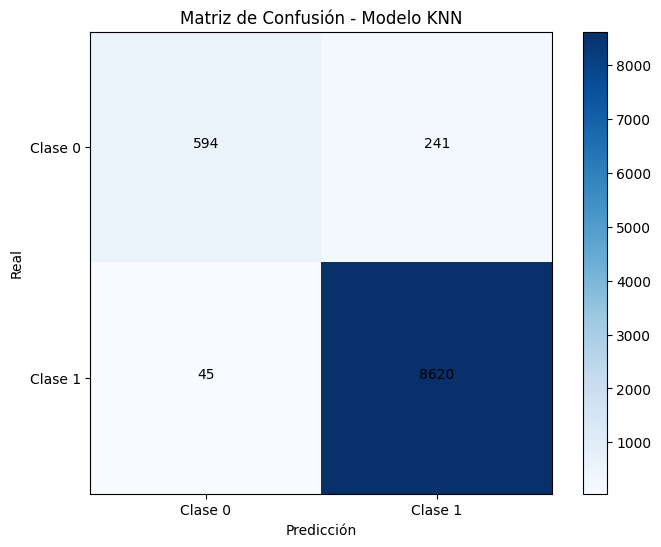

In [ ]:
# Obtener las predicciones del modelo KNN
y_pred_knn = knn_model.predict(X_test)

# Calcular la matriz de confusión
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_knn, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - Modelo KNN")
plt.colorbar()
tick_marks = range(len(np.unique(y_test)))
plt.xticks(tick_marks, ["Clase 0", "Clase 1"])
plt.yticks(tick_marks, ["Clase 0", "Clase 1"])

# Etiquetas y valores en la matriz
for i in range(conf_matrix_knn.shape[0]):
    for j in range(conf_matrix_knn.shape[1]):
        plt.text(j, i, conf_matrix_knn[i, j], horizontalalignment="center", color="black")

plt.ylabel("Real")
plt.xlabel("Predicción")
plt.show()

## Matriz de confusión modelo SVM

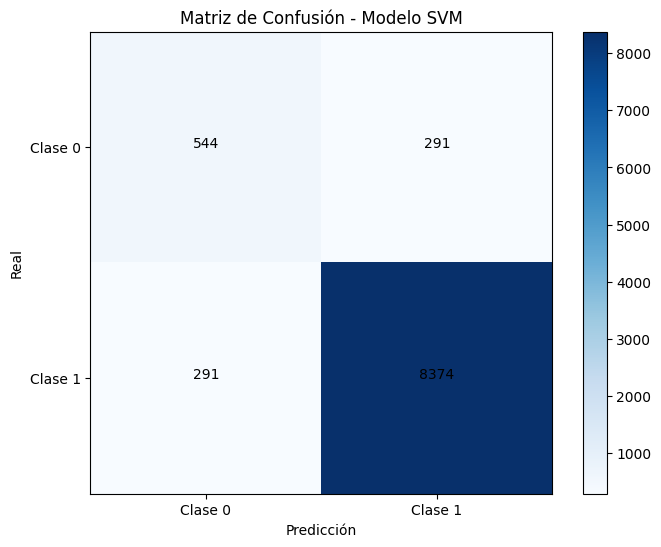

In [ ]:
# Obtener las predicciones del modelo SVM
y_pred_svm = svm_model.predict(X_test)

# Calcular la matriz de confusión
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_svm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - Modelo SVM")
plt.colorbar()
tick_marks = range(len(np.unique(y_test)))
plt.xticks(tick_marks, ["Clase 0", "Clase 1"])
plt.yticks(tick_marks, ["Clase 0", "Clase 1"])

# Etiquetas y valores en la matriz
for i in range(conf_matrix_svm.shape[0]):
    for j in range(conf_matrix_svm.shape[1]):
        plt.text(j, i, conf_matrix_svm[i, j], horizontalalignment="center", color="black")

plt.ylabel("Real")
plt.xlabel("Predicción")
plt.show()

## Matriz de confusión modelo SVM

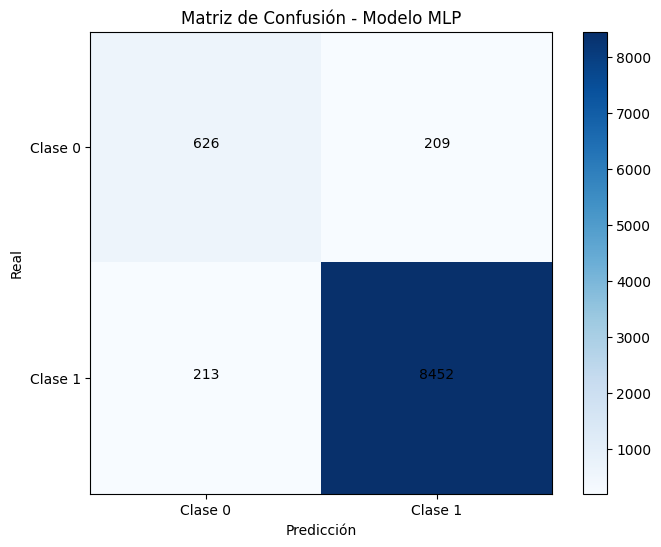

In [ ]:
# Obtener las predicciones del modelo MLP
y_pred_mlp = mlp_model.predict(X_test)

# Calcular la matriz de confusión
conf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_mlp, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - Modelo MLP")
plt.colorbar()
tick_marks = range(len(np.unique(y_test)))
plt.xticks(tick_marks, ["Clase 0", "Clase 1"])
plt.yticks(tick_marks, ["Clase 0", "Clase 1"])

# Etiquetas y valores en la matriz
for i in range(conf_matrix_mlp.shape[0]):
    for j in range(conf_matrix_mlp.shape[1]):
        plt.text(j, i, conf_matrix_mlp[i, j], horizontalalignment="center", color="black")

plt.ylabel("Real")
plt.xlabel("Predicción")
plt.show()

## Graficar todas las curvas ROC

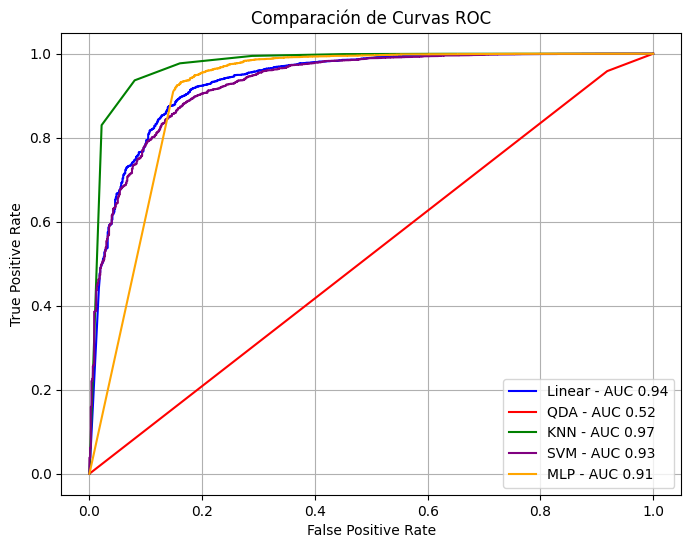

In [ ]:
# Graficar todas las curvas ROC
plt.figure(figsize=(8, 6))

# Curva ROC del modelo Linear
plt.plot(fpr_linear, tpr_linear, label=f"Linear - AUC {roc_auc_linear:.2f}", color="blue")

# Curva ROC del modelo QDA
plt.plot(fpr_qda, tpr_qda, label=f"QDA - AUC {roc_auc_qda:.2f}", color="red")

# Curva ROC del modelo KNN
plt.plot(fpr_knn, tpr_knn, label=f"KNN - AUC {roc_auc_knn:.2f}", color="green")

# Curva ROC del modelo SVM
plt.plot(fpr_svm, tpr_svm, label=f"SVM - AUC {roc_auc_svm:.2f}", color="purple")

# Curva ROC del modelo MLP
plt.plot(fpr_mlp, tpr_mlp, label=f"MLP - AUC {roc_auc_mlp:.2f}", color="orange")

# Configurar la gráfica
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparación de Curvas ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()